In [1]:
%matplotlib  inline
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
    
from pykalman import KalmanFilter
pd.set_option('display.max_columns', 150)
pd.options.display.max_rows = 150


In [2]:
def find_nearest(array, value,findMax=True):

    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    #print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, tolerance):
    """Group extremes by cluster based on relative price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= tolerance*item:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r   

def calc_extreme_groups (dataframe,find_max=True,mDistance = 100,tolerance=0.0009,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,tolerance)
    return array,signify,extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr


In [19]:
df = pd.read_pickle('results_hold_6.75_profit_0.0016.pkl')
EURUSD_D = df.resample('1D').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_D['PctChangeClose'] = EURUSD_D.CLOSE.pct_change().dropna()
EURUSD_D['Weekday'] = EURUSD_D.index.weekday
EURUSD_D['Month'] = EURUSD_D.index.month
EURUSD_D['DayMonth'] = EURUSD_D.index.day
EURUSD_D['Hour'] = EURUSD_D.index.hour

EURUSD_M = df.resample('M').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_M['PctChangeClose'] = EURUSD_M.CLOSE.dropna().pct_change().dropna()
EURUSD_M['Month'] = EURUSD_M.index.month

# local extremes

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


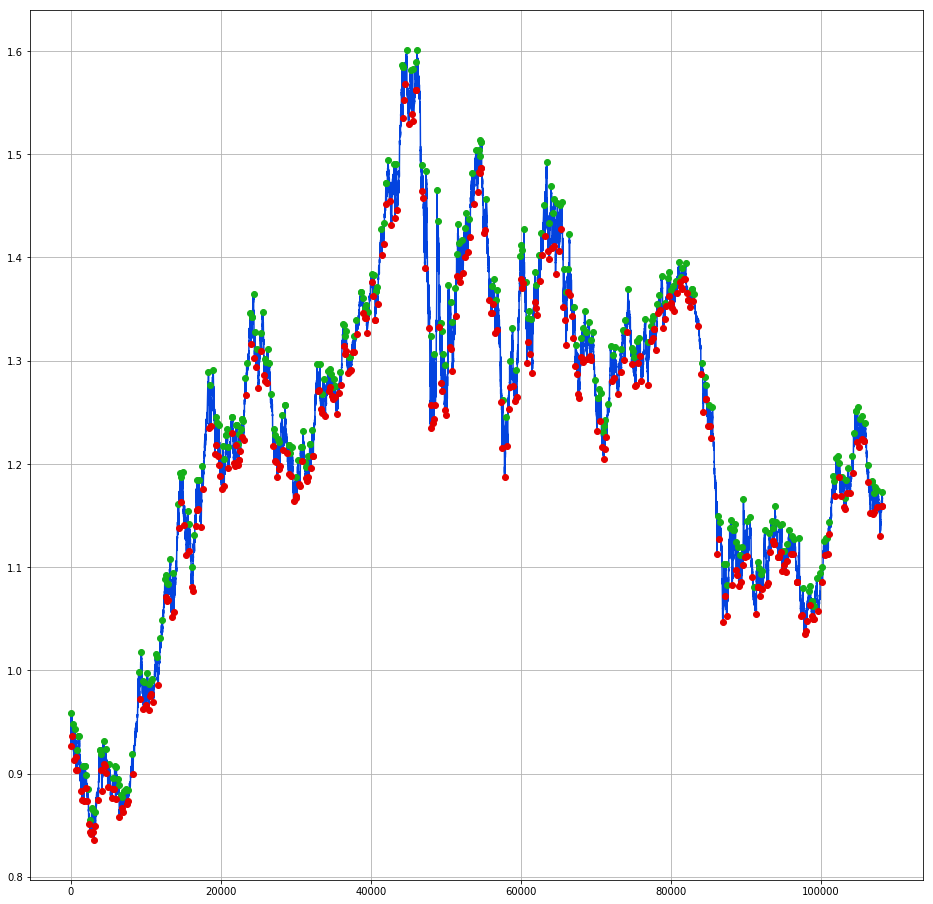

In [4]:
cl=np.ravel(df[['CLOSE']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 100
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

# Resistance levels

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


localextremes:620
signify:21  signimax:3.0
extremes:17
final extremes:22


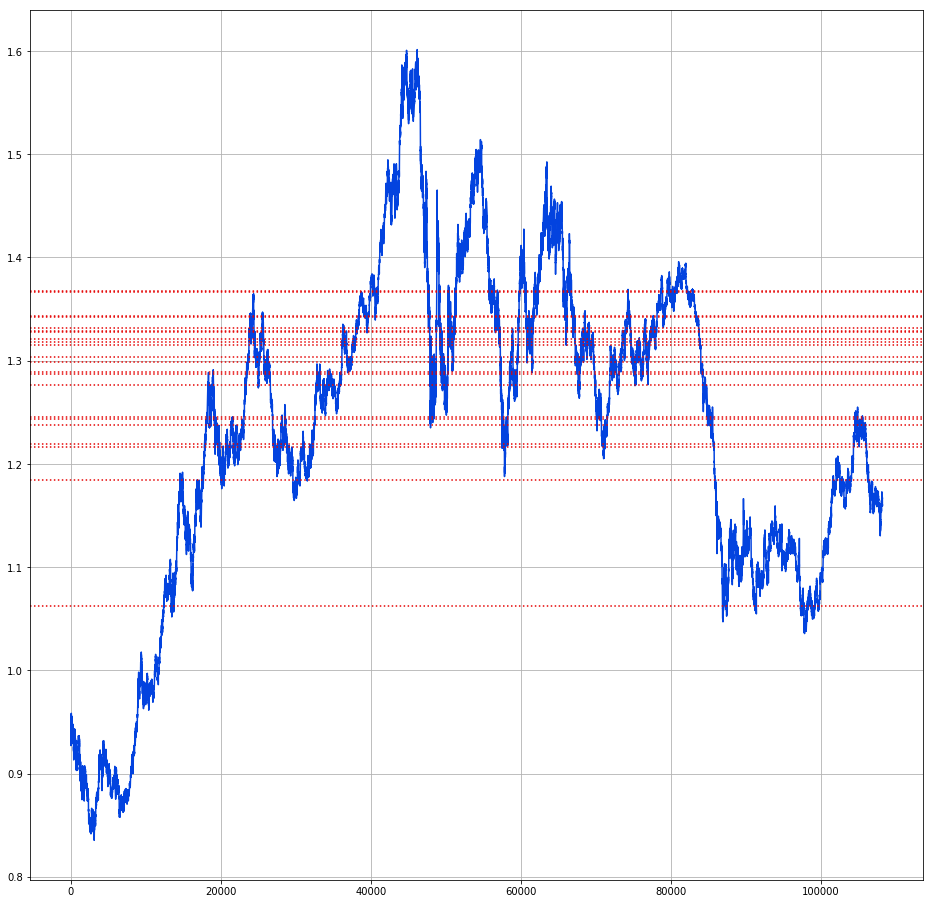

In [5]:
tolerance= 0.0001
signi_level=2
min_distance= 60
array = np.ravel(cl[local_extreme(cl,min_distance= min_distance,find_max=False)])
#signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
extreme = group_extremes(signify,tolerance)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
      
_,_,extremes_res = calc_extreme_groups(df[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=True)

print('final extremes:' + repr(len(extremes_res))) 
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

# Support levels

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:121: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


localextremes:620
signify:21  signimax:3.0
extremes:17


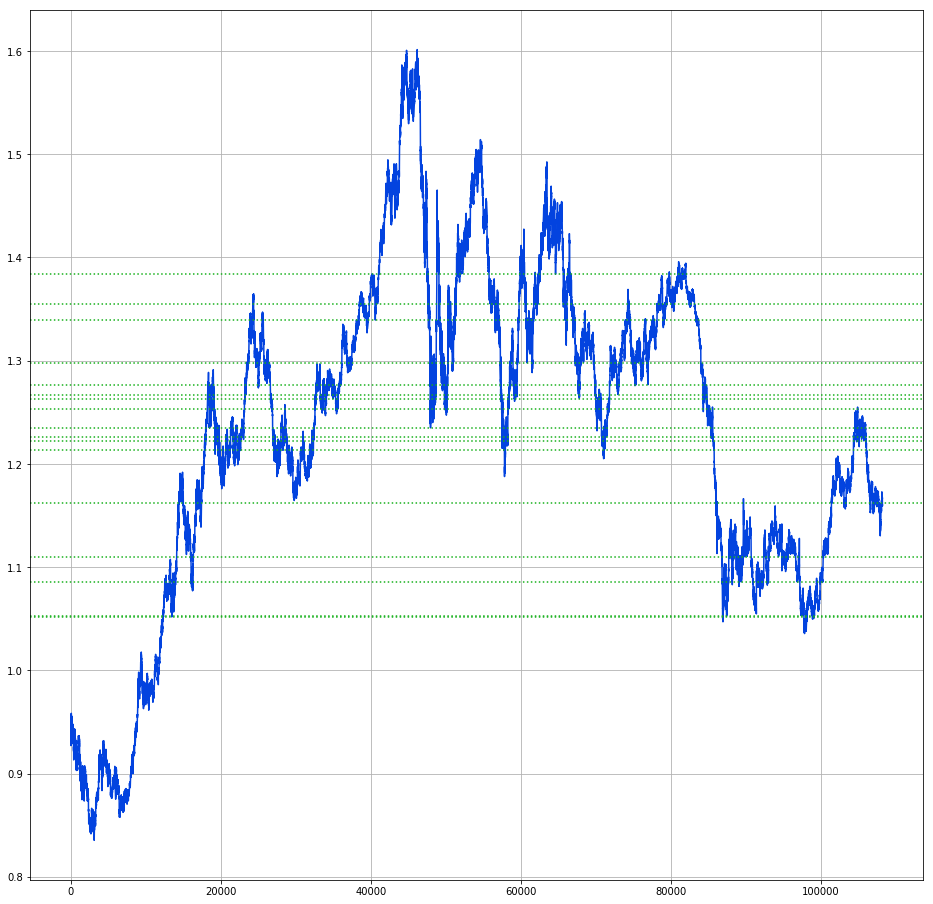

In [6]:
# Show horizontal resistance levels based on extreme points and significance
__,__,extremes_sup = calc_extreme_groups(df[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=False)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

# mean weekday performance strategy

Text(0.5,1,'Mean close to close return per weekday')

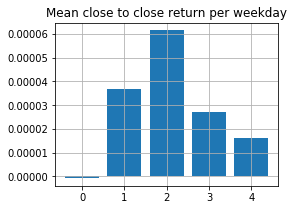

In [35]:
bars = df[df.Weekday <=5].groupby(['Weekday'])['pct_change'].mean()
plt.rc("figure",figsize=(4,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean close to close return per weekday')

# mean weekday performance day to day

Text(0.5,1,'Mean day close to day close return per weekday')

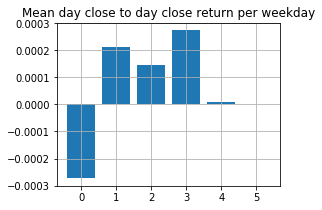

In [34]:
bars = EURUSD_D[EURUSD_D.Weekday <=5].groupby(['Weekday']).PctChangeClose.mean()
plt.rc("figure",figsize=(4,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean day close to day close return per weekday')

# mean weekday signal strategy

Text(0.5,1,'Bar 6 = Sunday 23:00')

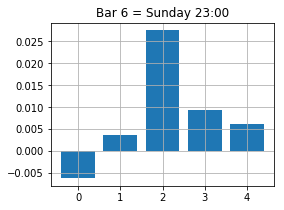

In [33]:
bars = df[df.Weekday <=5].groupby(['Weekday'])['signal'].mean()
plt.rc("figure",figsize=(4,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# mean daymonth performance strategy

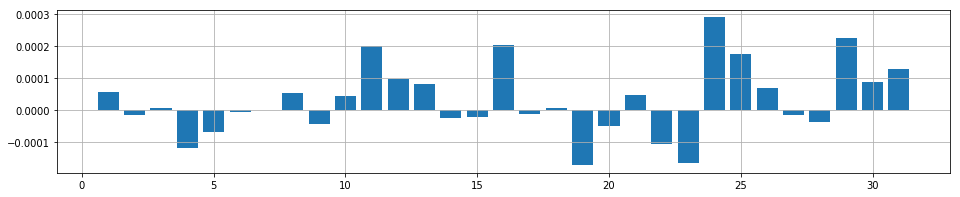

In [10]:
bars = df.groupby(['DayMonth'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean daymonth performance close to close

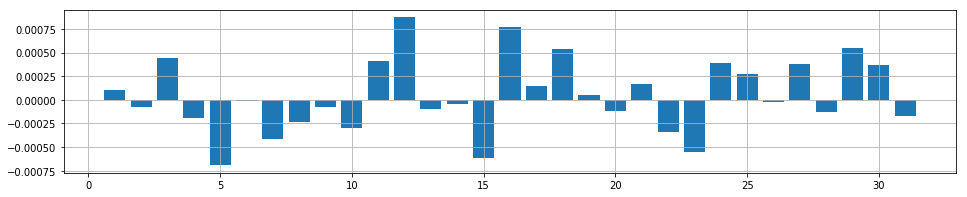

In [11]:
bars = EURUSD_D.groupby(['DayMonth']).PctChangeClose.mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month signal strategy

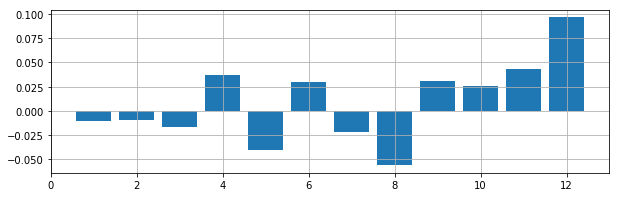

In [32]:
bars = df.groupby(['Month'])['signal'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month to month performance

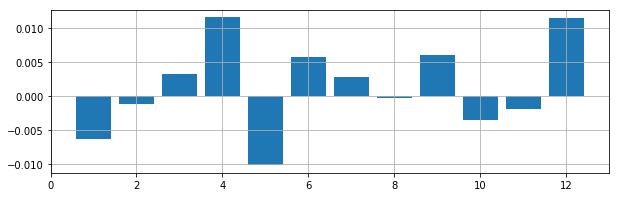

In [31]:
bars = EURUSD_M.groupby(['Month']).PctChangeClose.mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()

# mean hour to hour close performance  (EST timezone : 6:00-15:00)

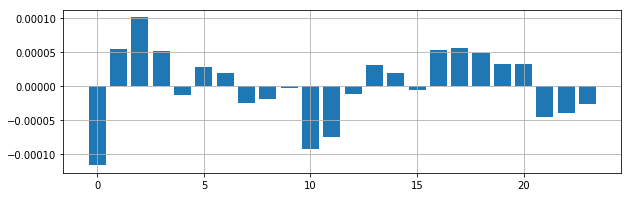

In [36]:
df['Hour'] = df.index.hour
df['PctChangeClose'] = df.CLOSE.pct_change().dropna()
bars = df.groupby(['Hour']).PctChangeClose.mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()

# hour to hour close standard deviation (EST timezone : 6:00-15:00)

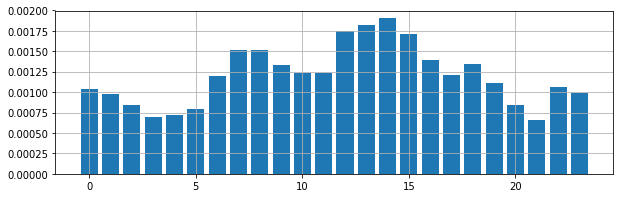

In [37]:
df['Hour'] = df.index.hour
df['TradingRange'] = df.HIGH-df.CLOSE
df['PctChangeClose'] = df.CLOSE.pct_change().dropna()
bars = df.groupby(['Hour']).PctChangeClose.std()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()

# mean hour to hour trading range  (EST timezone : 6:00-15:00)

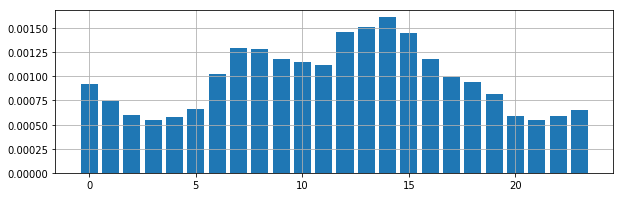

In [38]:
bars = df.groupby(['Hour']).TradingRange.mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()

# Correlation technical indicators and time features to signal

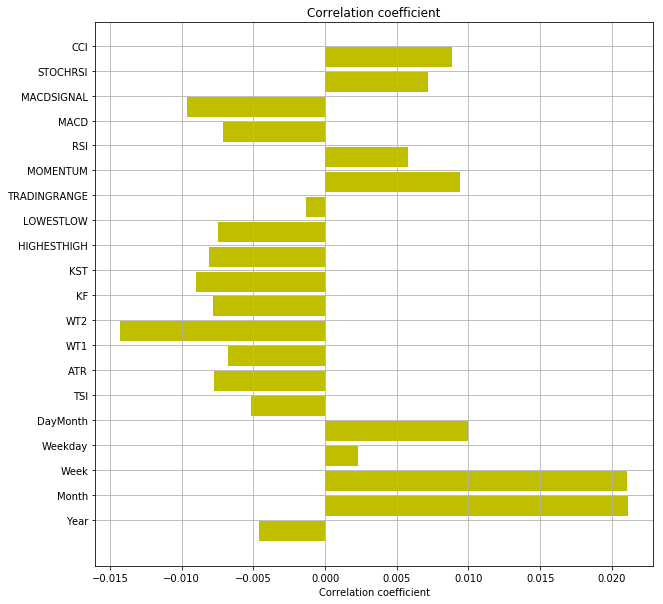

In [14]:
df = df.dropna()
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col in ['CCI','STOCHRSI','MACDSIGNAL','MACD','RSI','MOMENTUM','TRADINGRANGE',
                                                   'LOWESTLOW','HIGHESTHIGH','KST','KF','WT1','WT2','ATR','TSI',
                                              'DayMonth','Weekday','Week','Month','Year']]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# Correlation technical indicators and time features to pct_change

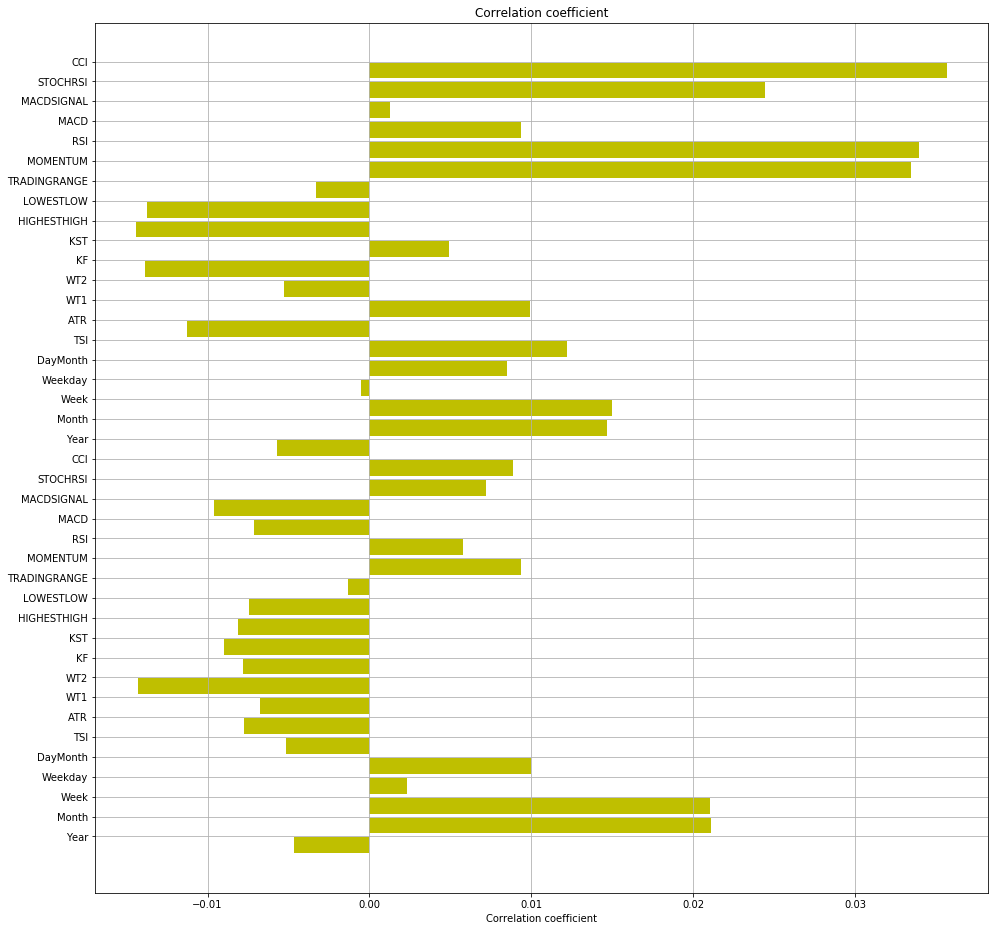

In [15]:
target_col = 'pct_change'
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# correlation calculated features to pct_change

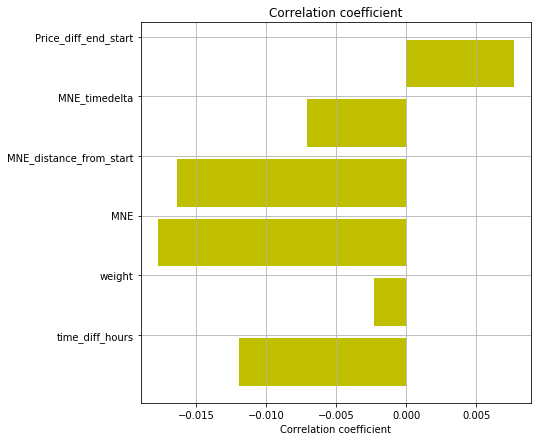

In [16]:
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col in ['time_diff_hours','weight','MNE','MNE_distance_from_start','MNE_timedelta',
                                              'Price_diff_end_start']]

target_col = 'pct_change'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(7,7))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()
